# HEC-RAS 1D HDF Data Analysis Notebook

This notebook demonstrates how to manipulate and analyze HEC-RAS 2D HDF data using the ras-commander library. It leverages the HdfBase, HdfUtils, HdfStruc, HdfMesh, HdfXsec, HdfBndry, HdfPlan, HdfResultsPlan, HdfResultsMesh, and HdfResultsXsec classes to streamline data extraction, processing, and visualization.


## Importing ras-commander flexibly (from package or local dev copy)

In [1]:
# Install ras-commander from pip (uncomment to install if needed)
#!pip install --upgrade ras-commander
# This installs ras-commander and all dependencies

In [2]:
# Import all required modules
from ras_commander import *  # Import all ras-commander modules

# Import the required libraries for this notebook
import h5py
import numpy as np
import pandas as pd
import requests
from tqdm import tqdm
import scipy
import xarray as xr
import geopandas as gpd
import matplotlib.pyplot as plt
from IPython import display
import psutil  # For getting system CPU info
from concurrent.futures import ThreadPoolExecutor, as_completed
import time
import subprocess
import sys
import os
import shutil
from datetime import datetime, timedelta
from pathlib import Path  # Ensure pathlib is imported for file operations

# This cell will try to import the pip package, if it fails it will 
# add the parent directory to the Python path and try to import again
# This assumes you are working in a subfolder of the ras-commander repository
# This allows a user's revisions to be tested locally without installing the package

import sys
from pathlib import Path

# Flexible imports to allow for development without installation 
#  ** Use this version with Jupyter Notebooks **
try:
    # Try to import from the installed package
    from ras_commander import *
except ImportError:
    # If the import fails, add the parent directory to the Python path
    import os
    current_file = Path(os.getcwd()).resolve()
    rascmdr_directory = current_file.parent
    sys.path.append(str(rascmdr_directory))
    print("Loading ras-commander from local dev copy")
    # Now try to import again
    from ras_commander import *
print("ras_commander imported successfully")


In [3]:
# Download the BaldEagleCrkMulti2D project from HEC and run plan 01

# Define the path to the BaldEagleCrkMulti2D project
current_dir = Path.cwd()  # Adjust if your notebook is in a different directory
bald_eagle_path = current_dir / "example_projects" / "Balde Eagle Creek"
import logging

# Check if BaldEagleCrkMulti2D.p06.hdf exists (so we don't have to re-run the simulation when re-running or debugging)
hdf_file = bald_eagle_path / "BaldEagle.p01.hdf"

if not hdf_file.exists():
    # Initialize RasExamples and extract the BaldEagleCrkMulti2D project
    RasExamples.extract_project("Balde Eagle Creek")

    # Initialize the RAS project using the custom ras object
    init_ras_project(bald_eagle_path, "6.6")
    logging.info(f"Balde Eagle project initialized with folder: {ras.project_folder}")
    
    logging.info(f"Balde Eagle object id: {id(ras)}")
    
    # Define the plan number to execute
    plan_number = "01"

    # Execute Plan 06 using RasCmdr for Bald Eagle
    print(f"Executing Plan {plan_number} for the Bald Eagle Creek project...")
    success_bald_eagle = RasCmdr.compute_plan(plan_number)
    if success_bald_eagle:
        print(f"Plan {plan_number} executed successfully for Bald Eagle.\n")
    else:
        print(f"Plan {plan_number} execution failed for Bald Eagle.\n")
else:
    print("BaldEagle.p01.hdf already exists. Skipping project extraction and plan execution.")
    # Initialize the RAS project using the custom ras object
    bald_eagle = init_ras_project(bald_eagle_path, "6.6")
    plan_number = "01"

2025-03-15 08:33:46 - ras_commander.RasExamples - WARNING - No existing example projects zip file found.
2025-03-15 08:33:46 - ras_commander.RasExamples - INFO - No example projects zip file found. Downloading...
2025-03-15 08:33:46 - ras_commander.RasExamples - INFO - Getting example projects for version 6.6
2025-03-15 08:33:46 - ras_commander.RasExamples - INFO - Downloading HEC-RAS Example Projects from https://github.com/HydrologicEngineeringCenter/hec-downloads/releases/download/1.0.33/Example_Projects_6_6.zip. 
The file is over 400 MB, so it may take a few minutes to download....
2025-03-15 08:33:50 - ras_commander.RasExamples - INFO - Downloaded to c:\GH\ras-commander\examples\Example_Projects_6_6.zip
2025-03-15 08:33:50 - ras_commander.RasExamples - INFO - Extracting folder structure from zip file...
2025-03-15 08:33:50 - ras_commander.RasExamples - INFO - Extracted 68 projects.
2025-03-15 08:33:50 - ras_commander.RasExamples - INFO - Saved project data to c:\GH\ras-commander\e

Executing Plan 01 for the Bald Eagle Creek project...


2025-03-15 08:38:40 - ras_commander.RasCmdr - INFO - HEC-RAS execution completed for plan: 01
2025-03-15 08:38:40 - ras_commander.RasCmdr - INFO - Total run time for plan 01: 289.79 seconds


Plan 01 executed successfully for Bald Eagle.



In [4]:
# Load Plan and Geometry Dataframes and find Plan and Geometry HDF Paths

# Display plan_df for bald_eagle project
print("Plan DataFrame for bald_eagle project:")
ras.plan_df

# Display geom_df for bald_eagle project
print("\nGeometry DataFrame for bald_eagle project:")
ras.geom_df

# Get the plan HDF path
plan_number = "01"  # Assuming we're using plan 01 as in the previous code
plan_hdf_path = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'HDF_Results_Path'].values[0]

# Get the geometry file number from the plan DataFrame
geom_file = ras.plan_df.loc[ras.plan_df['plan_number'] == plan_number, 'Geom File'].values[0]
geom_number = geom_file[1:]  # Remove the 'g' prefix

# Get the geometry HDF path
geom_hdf_path = ras.geom_df.loc[ras.geom_df['geom_number'] == geom_number, 'hdf_path'].values[0]

print(f"\nPlan HDF path for Plan {plan_number}: {plan_hdf_path}")
print(f"Geometry HDF path for Plan {plan_number}: {geom_hdf_path}")

Plan DataFrame for bald_eagle project:

Geometry DataFrame for bald_eagle project:

Plan HDF path for Plan 01: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf
Geometry HDF path for Plan 01: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf


-----

RasHdfUtils
| Method Name | Description |
|-------------|-------------|
| get_attrs | Converts attributes from a HEC-RAS HDF file into a Python dictionary for a given attribute path |
| get_root_attrs | Returns attributes at root level of HEC-RAS HDF file |
| get_hdf_paths_with_properties | Gets all paths in the HDF file with their properties |
| get_group_attributes_as_df | Gets attributes of a group in the HDF file as a DataFrame |
| get_hdf_filename | Gets the HDF filename from various input types |
| get_runtime_data | Extracts runtime and compute time data from a single HDF file |


In [5]:
# Get HDF Paths with Properties (For Exploring HDF Files)
HdfBase.get_dataset_info(plan_number, group_path="/Geometry")

2025-03-15 08:38:41 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Exploring group: /Geometry


    Group: /Geometry/Cross Section Interpolation Surfaces
    Attributes for /Geometry/Cross Section Interpolation Surfaces:
        Source Data Hash: [ 46 112  52  16   5 200 220 211  87  93 123 191 139  18 138 156 167   1
   2 140 201  58 178 145 110  17 213 166 178 174  73 200]
        Dataset: /Geometry/Cross Section Interpolation Surfaces/Areas
            Shape: (177,)
            Dtype: float32
        Dataset: /Geometry/Cross Section Interpolation Surfaces/Bounding Lines
            Shape: (177, 4)
            Dtype: int32
    Attributes for /Geometry/Cross Section Interpolation Surfaces/Bounding Lines:
        Column: [b'Left Bankline FID' b'Right Bankline FID' b'Left Edgeline FID'
 b'Right Edgeline FID']
        Row: b'Feature'
        Dataset: /Geometry/Cross Section Interpolation Surfaces/Orthogonal Vectors
            Shape: (177, 2)
            Dtype: float32
        Dataset: /Geometry/Cross Section Interpolation Surfaces/TIN Info
           

In [6]:
# Use HdfPlan for geometry-related operations
print("\nExample: Extracting Base Geometry Attributes")
geom_attrs = HdfPlan.get_geometry_information("01")  
# NOTE: Here we call the function using the plan number
geom_attrs

2025-03-15 08:38:41 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Example: Extracting Base Geometry Attributes
Getting geometry attributes from c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf
Checking for Geometry group in c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf
Getting root level geometry attributes
Successfully extracted root level geometry attributes


,Value
Complete Geometry,True
Extents,"[1966632.2513, 2066299.3787, 287473.1387, 3540..."
Geometry Time,2025-03-15 08:33:50
Title,Existing Conditions - GIS Data
Version,1.0.20 (20Sep2024)


In [7]:
# Example: Extract runtime and compute time data
print("\nExample 2: Extracting runtime and compute time data")
runtime_df = HdfResultsPlan.get_runtime_data("1") 
# NOTE: Here we use plan number "1" without the leading zero.  The decorator ensures that this still works


runtime_df


2025-03-15 08:38:41 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf
2025-03-15 08:38:41 - ras_commander.HdfResultsPlan - INFO - Extracting Plan Information from: BaldEagle.p01.hdf
2025-03-15 08:38:41 - ras_commander.HdfResultsPlan - INFO - Plan Name: Unsteady with Bridges and Dam
2025-03-15 08:38:41 - ras_commander.HdfResultsPlan - INFO - Simulation Duration (hours): 149.0



Example 2: Extracting runtime and compute time data


,Plan Name,File Name,Simulation Start Time,Simulation End Time,Simulation Duration (s),Simulation Time (hr),Completing Geometry (hr),Preprocessing Geometry (hr),Completing Event Conditions (hr),Unsteady Flow Computations (hr),Complete Process (hr),Unsteady Flow Speed (hr/hr),Complete Process Speed (hr/hr)
0,Unsteady with Bridges and Dam,BaldEagle.p01.hdf,1999-02-18,1999-02-24 05:00:00,536400.0,149.0,N/A,0.065503,N/A,0.002439,0.077153,61086.436625,1931.240076


Table of all the functions in the RasGeomHdf class from the ras_commander/RasGeomHdf.py file:

| Function Name | Description |
|---------------|-------------|
| projection | Returns the projection of the RAS geometry as a pyproj.CRS object |
| get_geom_attrs | Returns base geometry attributes from a HEC-RAS HDF file |

| mesh_area_names | Returns a list of the 2D mesh area names of the RAS geometry |
| get_geom_2d_flow_area_attrs | Returns geometry 2d flow area attributes from a HEC-RAS HDF file |
| mesh_areas | Returns 2D flow area perimeter polygons |
| mesh_cell_polygons | Returns 2D flow mesh cell polygons |
| mesh_cell_points | Returns 2D flow mesh cell points |
| mesh_cell_faces | Returns 2D flow mesh cell faces |

| get_geom_structures_attrs | Returns geometry structures attributes from a HEC-RAS HDF file |




| bc_lines | Returns 2D mesh area boundary condition lines |
| breaklines | Returns 2D mesh area breaklines |



| refinement_regions | Returns 2D mesh area refinement regions |
| structures | Returns the model structures |
| reference_lines_names | Returns reference line names |
| reference_points_names | Returns reference point names |
| reference_lines | Returns the reference lines geometry and attributes |
| reference_points | Returns the reference points geometry and attributes |
| cross_sections | Returns the model 1D cross sections |
| river_reaches | Returns the model 1D river reach lines |
| cross_sections_elevations | Returns the model cross section elevation information |

In [8]:
# For all of the RasGeomHdf Class Functions, we will use geom_hdf_path
print(geom_hdf_path)

# For the example project, plan 06 is associated with geometry 09
# If you want to call the geometry by number, call RasHdfGeom functions with a number
# Otherwise, if you want to look up geometry hdf path by plan number, follow the logic in the previous code cells

c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf


In [9]:
# Use HdfUtils for extracting projection
print("\nExtracting Projection from HDF")
projection = HdfBase.get_projection(hdf_path=geom_hdf_path)
if projection:
    print(f"Projection: {projection}")
else:
    print("No projection information found.  This attribute is only included if a RASMapper projection is defined.")

2025-03-15 08:38:41 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:41 - ras_commander.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



Extracting Projection from HDF
No projection information found.  This attribute is only included if a RASMapper projection is defined.


### The example project we are using does not have a projection, so error messages should be expected.  

In [10]:
# Use HdfPlan for geometry-related operations
print("\nExample: Extracting Base Geometry Attributes")
geom_attrs = HdfPlan.get_geometry_information(geom_hdf_path)
geom_attrs



2025-03-15 08:38:41 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf



Example: Extracting Base Geometry Attributes
Getting geometry attributes from c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
Checking for Geometry group in c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
Getting root level geometry attributes
Successfully extracted root level geometry attributes


,Value
Complete Geometry,True
Extents,"[1966632.2513, 2066299.3787, 287473.1387, 3540..."
Geometry Time,2025-03-15 08:33:50
Title,Existing Conditions - GIS Data
Version,1.0.20 (20Sep2024)


In [11]:
# Get geometry structures attributes
print("\nGetting geometry structures attributes")
geom_structures_attrs = HdfStruc.get_geom_structures_attrs(geom_hdf_path)
if geom_structures_attrs:
    print("Geometry structures attributes:")
    for key, value in geom_structures_attrs.items():
        print(f"{key}: {value}")
else:
    print("No geometry structures attributes found.")


Getting geometry structures attributes

2025-03-15 08:38:41 - ras_commander.HdfStruc - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf



Geometry structures attributes:
Bridge/Culvert Count: 10
Connection Count: 0
Has Bridge Opening (2D): 0
Inline Structure Count: 1
Lateral Structure Count: 0


### REVISION NOTE: NEED TO EDIT THIS TO SHOW BC LINES WITH RIVERS AND CROSS SECTIONS

# Example: Extract Boundary Condition Lines and Plot with 2D Flow Area Perimeter Polygons
print("\nExample 7: Extracting Boundary Condition Lines and Plotting with 2D Flow Area Perimeter Polygons")
bc_lines_df = HdfBndry.bc_lines(geom_hdf_path)
if not bc_lines_df.empty:
    display(bc_lines_df.head())
else:
    print("No Boundary Condition Lines found.")

# Plot if data exists
if not bc_lines_df.empty or not mesh_areas.empty:
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot 2D Flow Area Perimeter Polygons
    if not mesh_areas.empty:
        mesh_areas.plot(ax=ax, edgecolor='black', facecolor='none', alpha=0.7, label='2D Flow Area')
        
        # Add labels for each polygon
        for idx, row in mesh_areas.iterrows():
            centroid = row.geometry.centroid
            label = row.get('Name', f'Area {idx}')
            ax.annotate(label, (centroid.x, centroid.y), ha='center', va='center')
    
    # Plot boundary condition lines
    if not bc_lines_df.empty:
        bc_lines_df.plot(ax=ax, color='red', linewidth=2, label='Boundary Condition Lines')
    
    # Set labels and title
    ax.set_xlabel('Easting')
    ax.set_ylabel('Northing')
    ax.set_title('2D Flow Area Perimeter Polygons and Boundary Condition Lines')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    # Adjust layout and display
    plt.tight_layout()
    plt.show()
else:
    print("No data available for plotting.")

In [12]:
# INSTEAD OF hdf_input, USE plan_hdf_path or geom_hdf_path as appropriate 

In [13]:
# Example: Get structures
structures_gdf = HdfStruc.get_structures(geom_hdf_path)
print("Structures:")
if not structures_gdf.empty:
    structures_gdf
else:
    print("No structures found in the geometry file.")

2025-03-15 08:38:41 - ras_commander.HdfStruc - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:41 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:41 - ras_commander.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project
2025-03-15 08:38:41 - ras_commander.HdfStruc - INFO - Successfully extracted structures GeoDataFrame.
2025-03-15 08:38:41 - ras_commander.HdfStruc - INFO - Successfully extracted structures GeoDataFrame with attributes.


Structures:


In [14]:
# Example: Get reference lines
ref_lines_gdf = HdfBndry.get_reference_lines(geom_hdf_path)
print("\nReference Lines:")
if not ref_lines_gdf.empty:
    display(ref_lines_gdf.head())
else:
    print("No reference lines found in the geometry file.")

2025-03-15 08:38:41 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf



Reference Lines:
No reference lines found in the geometry file.


In [15]:
# Example: Get reference points
ref_points_gdf = HdfBndry.get_reference_points(geom_hdf_path)
print("\nReference Points:")
if not ref_points_gdf.empty:
    display(ref_points_gdf.head())
else:
    print("No reference points found in the geometry file.")

2025-03-15 08:38:41 - ras_commander.HdfBndry - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf



Reference Points:
No reference points found in the geometry file.


In [16]:
# Use the get_hdf5_dataset_info function from HdfUtils to explore the Cross Sections structure in the geometry HDF file

print("\nExploring Cross Sections structure in geometry file:")
print("HDF Base Path: /Geometry/Cross Sections ")
HdfBase.get_dataset_info(geom_hdf_path, group_path='/Geometry/Cross Sections')


2025-03-15 08:38:41 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf



Exploring Cross Sections structure in geometry file:
HDF Base Path: /Geometry/Cross Sections 

Exploring group: /Geometry/Cross Sections


    Dataset: /Geometry/Cross Sections/Attributes
        Shape: (178,)
        Dtype: [('River', 'S16'), ('Reach', 'S16'), ('RS', 'S8'), ('Name', 'S16'), ('Description', 'S512'), ('Len Left', '<f4'), ('Len Channel', '<f4'), ('Len Right', '<f4'), ('Left Bank', '<f4'), ('Right Bank', '<f4'), ('Friction Mode', 'S32'), ('Contr', '<f4'), ('Expan', '<f4'), ('Left Levee Sta', '<f4'), ('Left Levee Elev', '<f4'), ('Right Levee Sta', '<f4'), ('Right Levee Elev', '<f4'), ('HP Count', '<i4'), ('HP Start Elev', '<f4'), ('HP Vert Incr', '<f4'), ('HP LOB Slices', '<i4'), ('HP Chan Slices', '<i4'), ('HP ROB Slices', '<i4'), ('Ineff Block Mode', 'u1'), ('Obstr Block Mode', 'u1'), ('Default Centerline', 'u1'), ('Last Edited', 'S18')]

    Group: /Geometry/Cross Sections/Flow Distribution
        Dataset: /Geometry/Cross Sections/Flow Distribution/Flow Normalized She

In [17]:
# Example: Get cross section geodataframe
cross_sections_gdf = HdfXsec.get_cross_sections(geom_hdf_path)
with pd.option_context('display.max_columns', None):  # Show all columns
    cross_sections_gdf

cross_sections_gdf: 

| geometry | station_elevation | mannings_n | ineffective_blocks | River | Reach | RS | Name | Description | Len Left | Len Channel | Len Right | Left Bank | Right Bank | Friction Mode | Contr | Expan | Left Levee Sta | Left Levee Elev | Right Levee Sta | Right Levee Elev | HP Count | HP Start Elev | HP Vert Incr | HP LOB Slices | HP Chan Slices | HP ROB Slices | Ineff Block Mode | Obstr Block Mode | Default Centerline | Last Edited |
|-----------|-------------------|------------|--------------------|-------|-------|----|------|-------------|----------|-------------|-----------|-----------|------------|----------------|-------|-------|----------------|-----------------|----------------|------------------|----------|----------------|---------------|----------------|----------------|----------------|------------------|------------------|-------------------|--------------|
| 0         | LINESTRING (1968668.17 290166.79, 1969067.87 2... | [[0.0, 660.41], [5.0, 660.61], [40.0, 659.85],... | {'Station': [0.0, 190.0, 375.0], 'Mann n': [0.... | []    | Bald Eagle | Loc Hav | 138154.4 |             | 358.429993 | 463.640015 | 517.640015 | 190.000000 | 375.000000 | Basic Mann n | 0.1   | 0.3   | NaN            | NaN             | NaN            | NaN              | 49       | 656.799988      | 1.0           | 5              | 5              | 5              | 0                | 0                | 0                 | 18Sep2000 09:10:52 |
| 1         | LINESTRING (1968627.02 290584.12, 1969009.09 2... | [[0.0, 664.28], [50.0, 661.73], [55.0, 661.54]... | {'Station': [0.0, 535.0, 672.5599975585938], '... | []    | Bald Eagle | Loc Hav | 137690.8 |             | 305.709991 | 363.839996 | 382.829987 | 535.000000 | 672.559998 | Basic Mann n | 0.1   | 0.3   | NaN            | NaN             | NaN            | NaN              | 65       | 654.229980      | 1.0           | 5              | 5              | 5              | 0                | 0                | 0                 | 18Sep2000 09:10:52 |
| 2         | LINESTRING (1968585.88 290854.5, 1968868.02 29... | [[0.0, 662.72], [20.0, 665.5], [25.0, 666.48],... | {'Station': [0.0, 580.0, 717.239990234375], 'M... | []    | Bald Eagle | Loc Hav | 137327.0 |             | 732.929993 | 762.020020 | 765.359985 | 580.000000 | 717.239990 | Basic Mann n | 0.1   | 0.3   | NaN            | NaN             | NaN            | NaN              | 66       | 653.900024      | 1.0           | 5              | 5              | 5              | 0                | 0                | 0                 | 18Sep2000 09:10:52 |


In [18]:
# Filter rows where ineffective_blocks is not empty
ineffective_xs = cross_sections_gdf[cross_sections_gdf['ineffective_blocks'].apply(len) > 0]

print("\nCross Sections with Ineffective Flow Areas:")
ineffective_xs

# Print a message if no cross sections with ineffective flow areas are found
print("\nNo cross sections found with ineffective flow areas." if ineffective_xs.empty else "")



Cross Sections with Ineffective Flow Areas:



In [19]:
# Print cross sections data

print("\nCross Section Information:")
if not cross_sections_gdf.empty:
    for idx, row in cross_sections_gdf.iterrows():
        print(f"\nCross Section {idx + 1}:")
        print(f"River: {row['River']}")
        print(f"Reach: {row['Reach']}")
        print("\nGeometry:")
        print(row['geometry'])
        print("\nStation-Elevation Points:")
        
        # Print header
        print("     #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation")
        print("-" * 150)
        
        # Calculate number of rows needed
        points = row['station_elevation']
        num_rows = (len(points) + 4) // 5  # Round up division
        
        # Print points in 5 columns
        for i in range(num_rows):
            line = ""
            for j in range(5):
                point_idx = i + j * num_rows
                if point_idx < len(points):
                    station, elevation = points[point_idx]
                    line += f"{point_idx+1:6d} {station:10.2f} {elevation:10.2f}    "
            print(line)
        print("-" * 150)
else:
    print("No cross sections found in the geometry file.")



Cross Section Information:

Cross Section 1:
River: Bald Eagle
Reach: Loc Hav

Geometry:
LINESTRING (1968668.17 290166.79, 1969067.87 289778.85)

Station-Elevation Points:
     #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation        #      Station   Elevation
------------------------------------------------------------------------------------------------------------------------------------------------------
     1       0.00     660.41         9     190.00     660.21        17     330.00     660.95        25     410.00     671.32        33     480.00     695.50    
     2       5.00     660.61        10     195.00     658.98        18     340.00     659.56        26     415.00     672.91        34     485.00     696.55    
     3      40.00     659.85        11     197.96     657.39        19     345.00     658.84        27     430.00     678.12        35     514.99     701.46    
     4      55.00     659

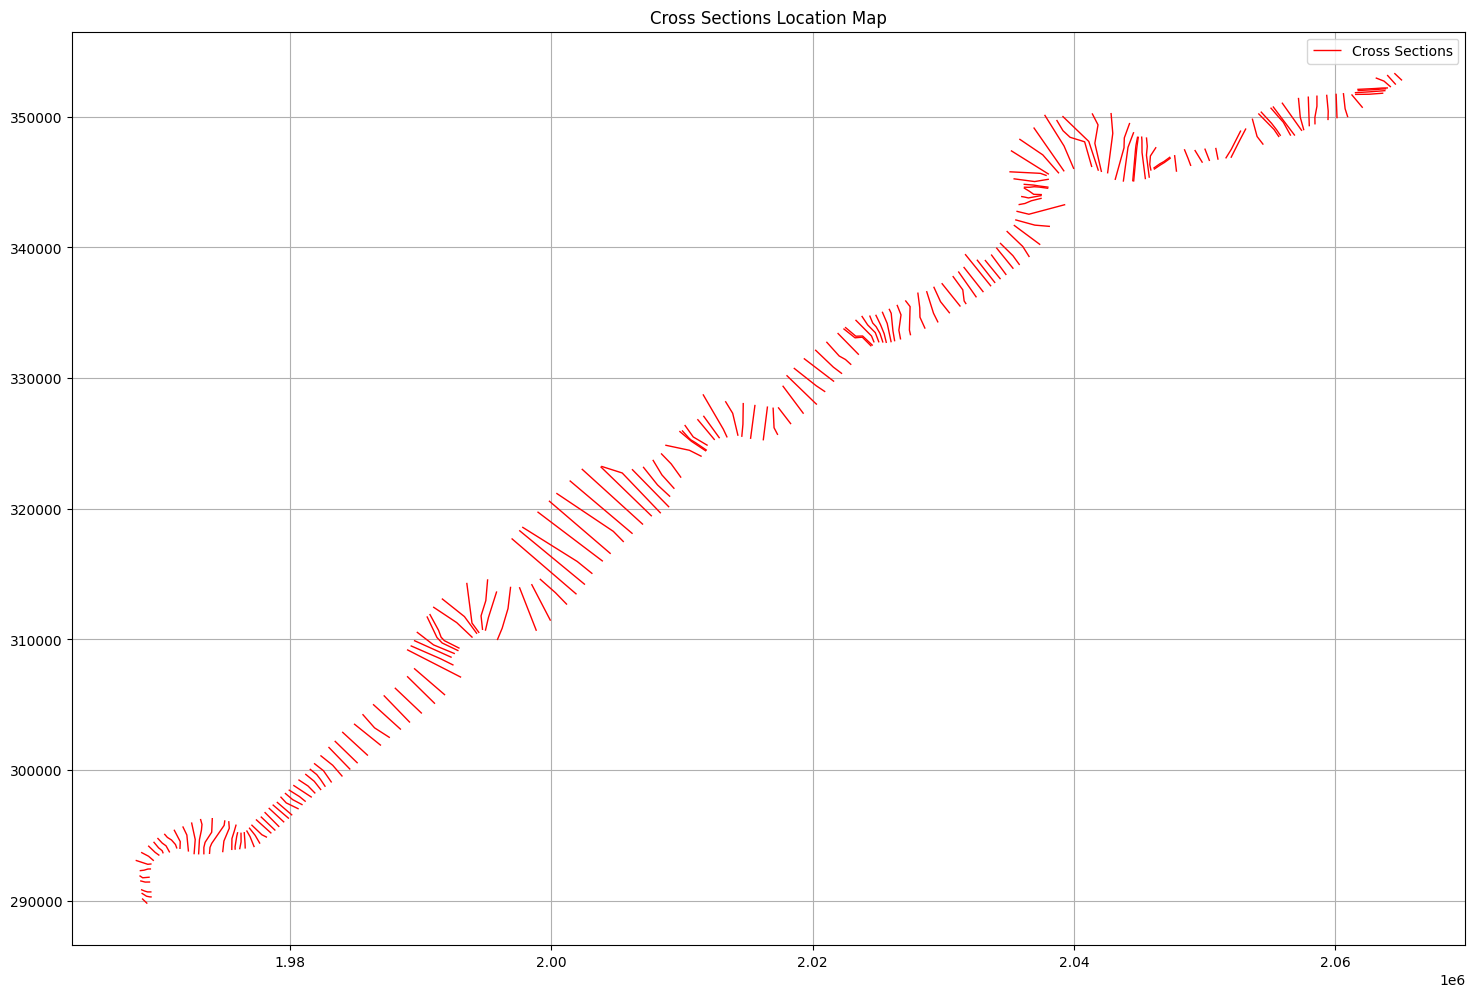

In [20]:
# Plot cross sections on map
import matplotlib.pyplot as plt

# Get cross sections data
cross_sections_gdf = HdfXsec.get_cross_sections(geom_hdf_path)

if not cross_sections_gdf.empty:
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(15,10))
    
    # Plot cross sections
    cross_sections_gdf.plot(ax=ax, color='red', linewidth=1, label='Cross Sections')
    
    # Add river name and reach labels
    #for idx, row in cross_sections_gdf.iterrows():
    #    # Get midpoint of cross section line for label placement
    #    midpoint = row.geometry.centroid
    #    label = f"{row['River']}\n{row['Reach']}\nRS: {row['RS']}"
    #    ax.annotate(label, (midpoint.x, midpoint.y), 
    #               xytext=(5, 5), textcoords='offset points',
    #               fontsize=8, bbox=dict(facecolor='white', alpha=0.7))
    
    # Customize plot
    ax.set_title('Cross Sections Location Map')
    ax.grid(True)
    ax.legend()
    
    # Equal aspect ratio to preserve shape
    ax.set_aspect('equal')
    
    plt.tight_layout()
    plt.show()
else:
    print("No cross sections found in the geometry file.")



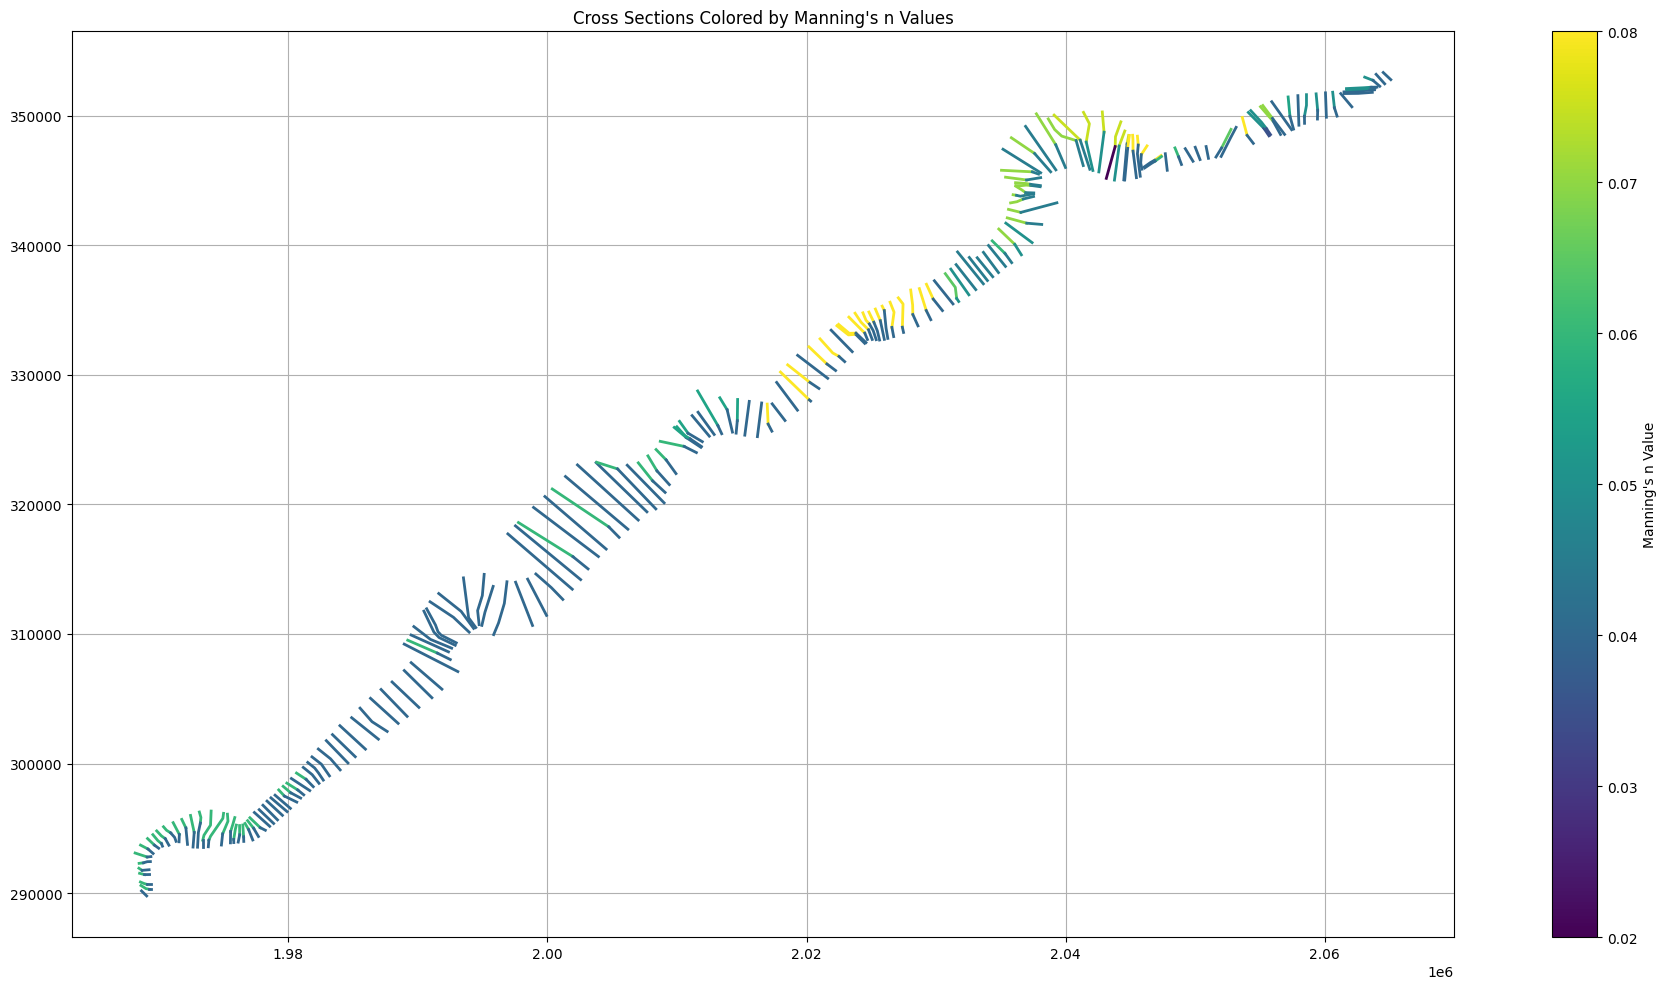

In [21]:
# Plot cross sections with Manning's n values colored by value
import matplotlib.pyplot as plt
import numpy as np
from shapely.geometry import LineString

# Create figure
fig, ax1 = plt.subplots(figsize=(20,10))

# Create colormap
cmap = plt.cm.viridis
norm = plt.Normalize(vmin=0.02, vmax=0.08)  # Typical Manning's n range

# Plot cross sections colored by Manning's n
for idx, row in cross_sections_gdf.iterrows():
    # Extract Manning's n values and stations
    mannings = row['mannings_n']
    n_values = mannings['Mann n']
    stations = mannings['Station']
    
    # Get the full linestring coordinates
    line_coords = list(row.geometry.coords)
    
    # Calculate total length of the cross section
    total_length = row.geometry.length
    
    # For each Manning's n segment
    for i in range(len(n_values)-1):
        # Calculate the start and end proportions along the line
        start_prop = stations[i] / stations[-1]
        end_prop = stations[i+1] / stations[-1]
        
        # Get the start and end points for this segment
        start_idx = int(start_prop * (len(line_coords)-1))
        end_idx = int(end_prop * (len(line_coords)-1))
        
        # Extract the segment coordinates
        segment_coords = line_coords[start_idx:end_idx+1]
        
        if len(segment_coords) >= 2:
            # Create a line segment
            segment = LineString(segment_coords)
            
            # Get color from colormap for this n value
            color = cmap(norm(n_values[i]))
            
            # Plot the segment
            ax1.plot(*segment.xy, color=color, linewidth=2)

# Add colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=ax1, label="Manning's n Value")

ax1.set_title("Cross Sections Colored by Manning's n Values")
ax1.grid(True)
ax1.set_aspect('equal')

plt.tight_layout()
plt.show()



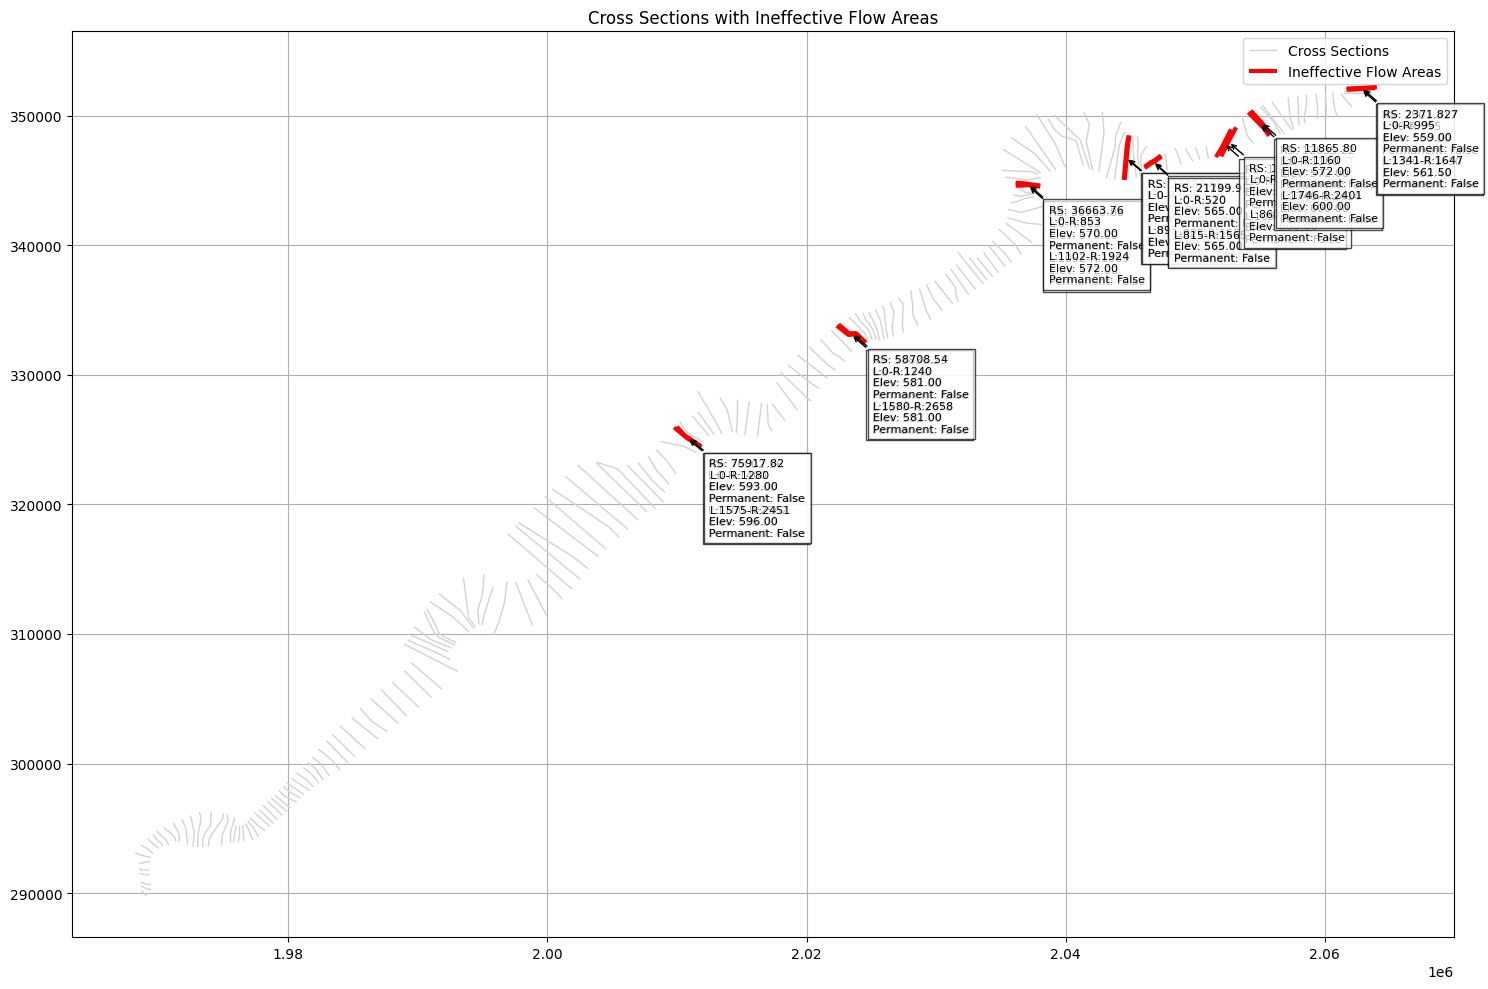

In [22]:
# Plot cross sections with ineffective flow areas
import matplotlib.pyplot as plt

# Get cross sections data
cross_sections_gdf = HdfXsec.get_cross_sections(geom_hdf_path)

# Create figure
fig, ax2 = plt.subplots(figsize=(20,10))

# Plot all cross sections first
cross_sections_gdf.plot(ax=ax2, color='lightgray', linewidth=1, label='Cross Sections')

# Plot ineffective flow areas with thicker lines
ineffective_sections = cross_sections_gdf[cross_sections_gdf['ineffective_blocks'].apply(lambda x: len(x) > 0)]
ineffective_sections.plot(ax=ax2, color='red', linewidth=3, label='Ineffective Flow Areas')

# Add ineffective flow area labels with offset to lower right
for idx, row in cross_sections_gdf.iterrows():
    # Get midpoint of cross section line
    midpoint = row.geometry.centroid
    
    # Extract ineffective flow blocks
    ineff_blocks = row['ineffective_blocks']
    
    if ineff_blocks:  # Only label if there are ineffective blocks
        label_parts = []
        # Add RS to first line of label
        label_parts.append(f"RS: {row['RS']}")
        for block in ineff_blocks:
            label_parts.append(
                f"L:{block['Left Sta']:.0f}-R:{block['Right Sta']:.0f}\n"
                f"Elev: {block['Elevation']:.2f}\n"
                f"Permanent: {block['Permanent']}"
            )
        
        label = '\n'.join(label_parts)
        
        ax2.annotate(label, (midpoint.x, midpoint.y),
                    xytext=(15, -15),  # Offset to lower right
                    textcoords='offset points',
                    fontsize=8, 
                    bbox=dict(facecolor='white', alpha=0.7),
                    arrowprops=dict(arrowstyle='->'),
                    horizontalalignment='left',
                    verticalalignment='top')

ax2.set_title('Cross Sections with Ineffective Flow Areas')
ax2.grid(True)
ax2.legend()
ax2.set_aspect('equal')

plt.tight_layout()
plt.show()

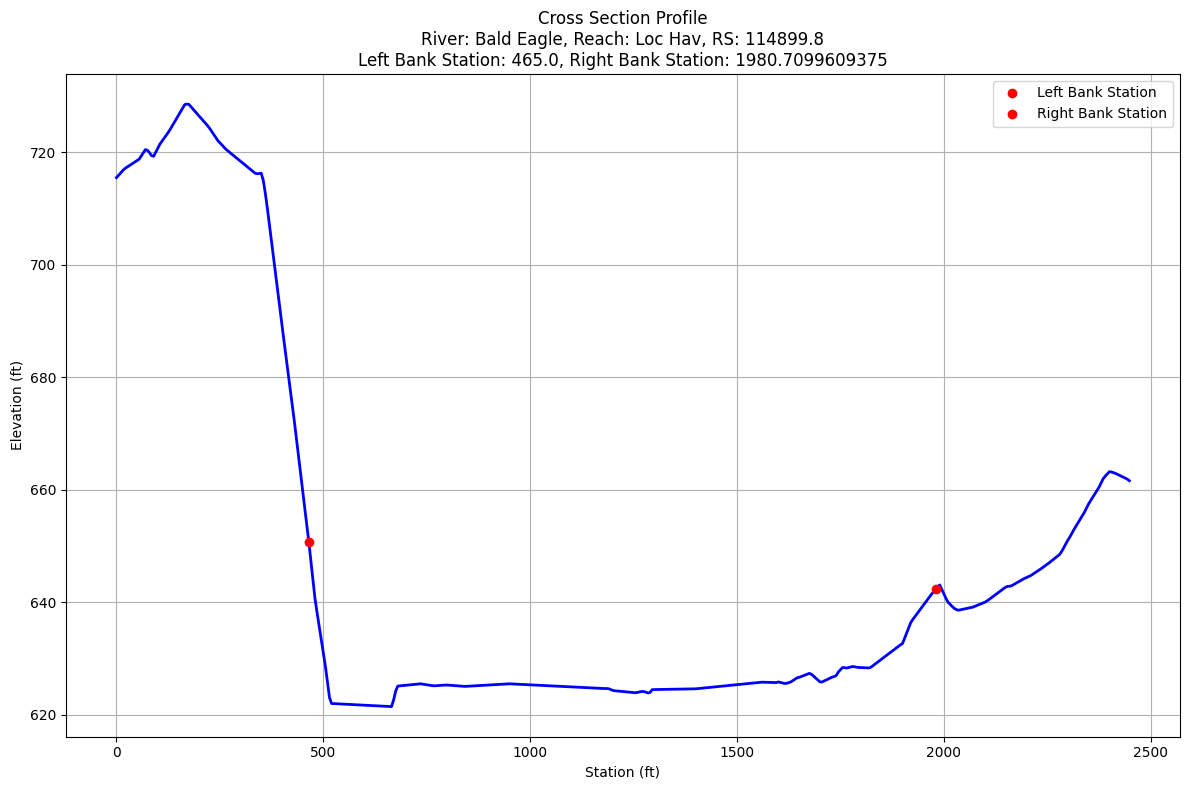

In [23]:
# Plot cross section elevation for cross section 42
import matplotlib.pyplot as plt
import numpy as np

# Get cross sections data
cross_sections_gdf = HdfXsec.get_cross_sections(geom_hdf_path)

if not cross_sections_gdf.empty:
    # Get station-elevation data for cross section 42
    station_elevation = cross_sections_gdf.iloc[42]['station_elevation']
    
    # Convert list of lists to numpy arrays for plotting
    stations = np.array([point[0] for point in station_elevation])
    elevations = np.array([point[1] for point in station_elevation])
    
    # Create figure and axis
    fig, ax = plt.subplots(figsize=(12,8))
    
    # Plot cross section
    ax.plot(stations, elevations, 'b-', linewidth=2)
    
    # Add labels and title
    river = cross_sections_gdf.iloc[42]['River']
    reach = cross_sections_gdf.iloc[42]['Reach'] 
    rs = cross_sections_gdf.iloc[42]['RS']
    
    # Show bank stations as dots
    left_bank_station = cross_sections_gdf.iloc[42]['Left Bank']
    right_bank_station = cross_sections_gdf.iloc[42]['Right Bank']
    
    # Interpolating bank stations for plotting
    ax.plot(left_bank_station, elevations[np.searchsorted(stations, left_bank_station)], 'ro', label='Left Bank Station')
    ax.plot(right_bank_station, elevations[np.searchsorted(stations, right_bank_station)], 'ro', label='Right Bank Station')
    
    ax.set_title(f'Cross Section Profile\nRiver: {river}, Reach: {reach}, RS: {rs}\n'
                 f'Left Bank Station: {left_bank_station}, Right Bank Station: {right_bank_station}')
    ax.set_xlabel('Station (ft)')
    ax.set_ylabel('Elevation (ft)')
    
    # Add grid and legend
    ax.grid(True)
    ax.legend()
    
    plt.tight_layout()
    plt.show()
else:
    print("No cross sections found in the geometry file.")


In [24]:
# Example usage:
centerlines = HdfXsec.get_river_centerlines(geom_hdf_path)
centerlines_with_stations = HdfXsec.get_river_stationing(centerlines)

# Display results
print("\nRiver Centerlines:")
centerlines.head()

2025-03-15 08:38:48 - ras_commander.HdfXsec - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:48 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:48 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:48 - ras_commander.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project
2025-03-15 08:38:48 - ras_commander.HdfXsec - INFO - Extracted 1 river centerlines



River Centerlines:


,River Name,Reach Name,US Type,US Name,DS Type,DS Name,Junction to US XS,DS XS to Junction,geometry,length
0,Bald Eagle,Loc Hav,External,,External,,NaN,NaN,"LINESTRING (1967609.38 288126.34, 1967754.63 2...",140451.729879


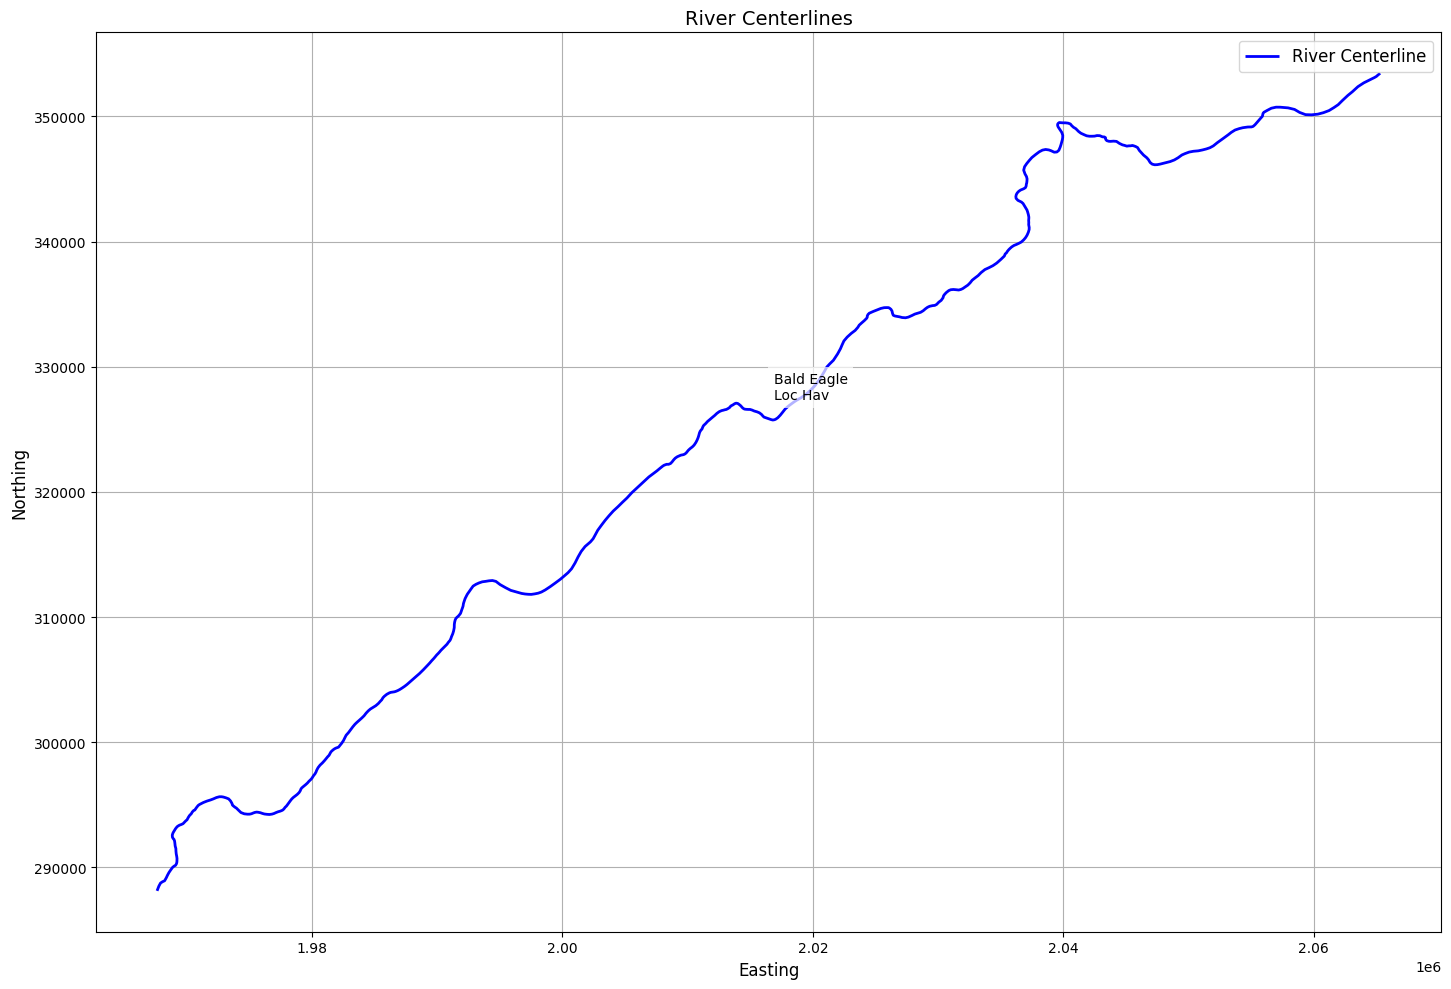

In [25]:
# Plot river centerlines with labels
import matplotlib.pyplot as plt
import geopandas as gpd

# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot centerlines
centerlines.plot(ax=ax, color='blue', linewidth=2, label='River Centerline')

# Add river/reach labels
for idx, row in centerlines.iterrows():
    # Get midpoint of the line for label placement
    midpoint = row.geometry.interpolate(0.5, normalized=True)
    
    # Create label text combining river and reach names
    label = f"{row['River Name']}\n{row['Reach Name']}"
    
    # Add text annotation
    ax.annotate(label, 
                xy=(midpoint.x, midpoint.y),
                xytext=(10, 10), # Offset text slightly
                textcoords='offset points',
                fontsize=10,
                bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

# Add labels and title
ax.set_title('River Centerlines', fontsize=14)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)

# Add legend
ax.legend(fontsize=12)

# Add grid
ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()



In [26]:
# Example usage:
edge_lines = HdfXsec.get_river_edge_lines(geom_hdf_path)
centerlines = HdfXsec.get_river_centerlines(geom_hdf_path)
# Display results
print("\nRiver Edge Lines:")
edge_lines.head()

2025-03-15 08:38:49 - ras_commander.HdfXsec - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:49 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:49 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:49 - ras_commander.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project
2025-03-15 08:38:49 - ras_commander.HdfXsec - INFO - Using HDF file: c:\GH\ras-comm


River Edge Lines:


,edge_id,bank_side,geometry,length
0,NaN,NaN,"LINESTRING (1968668.17 290166.79, 1968673.632 ...",141615.154108
1,NaN,NaN,"LINESTRING (1969067.87 289778.85, 1969194.669 ...",130396.337697


In [27]:
# Example usage:
bank_lines = HdfXsec.get_river_bank_lines(geom_hdf_path)
# Display results
print("\nRiver Bank Lines:")
bank_lines.head()

2025-03-15 08:38:49 - ras_commander.HdfXsec - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:49 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:49 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:49 - ras_commander.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project



River Bank Lines:


,bank_id,bank_side,geometry,length
0,0,Left,"LINESTRING (1968804.51 290034.461, 1968930.093...",139546.829503
1,1,Right,"LINESTRING (1968937.263 289905.614, 1969101.06...",139349.187666


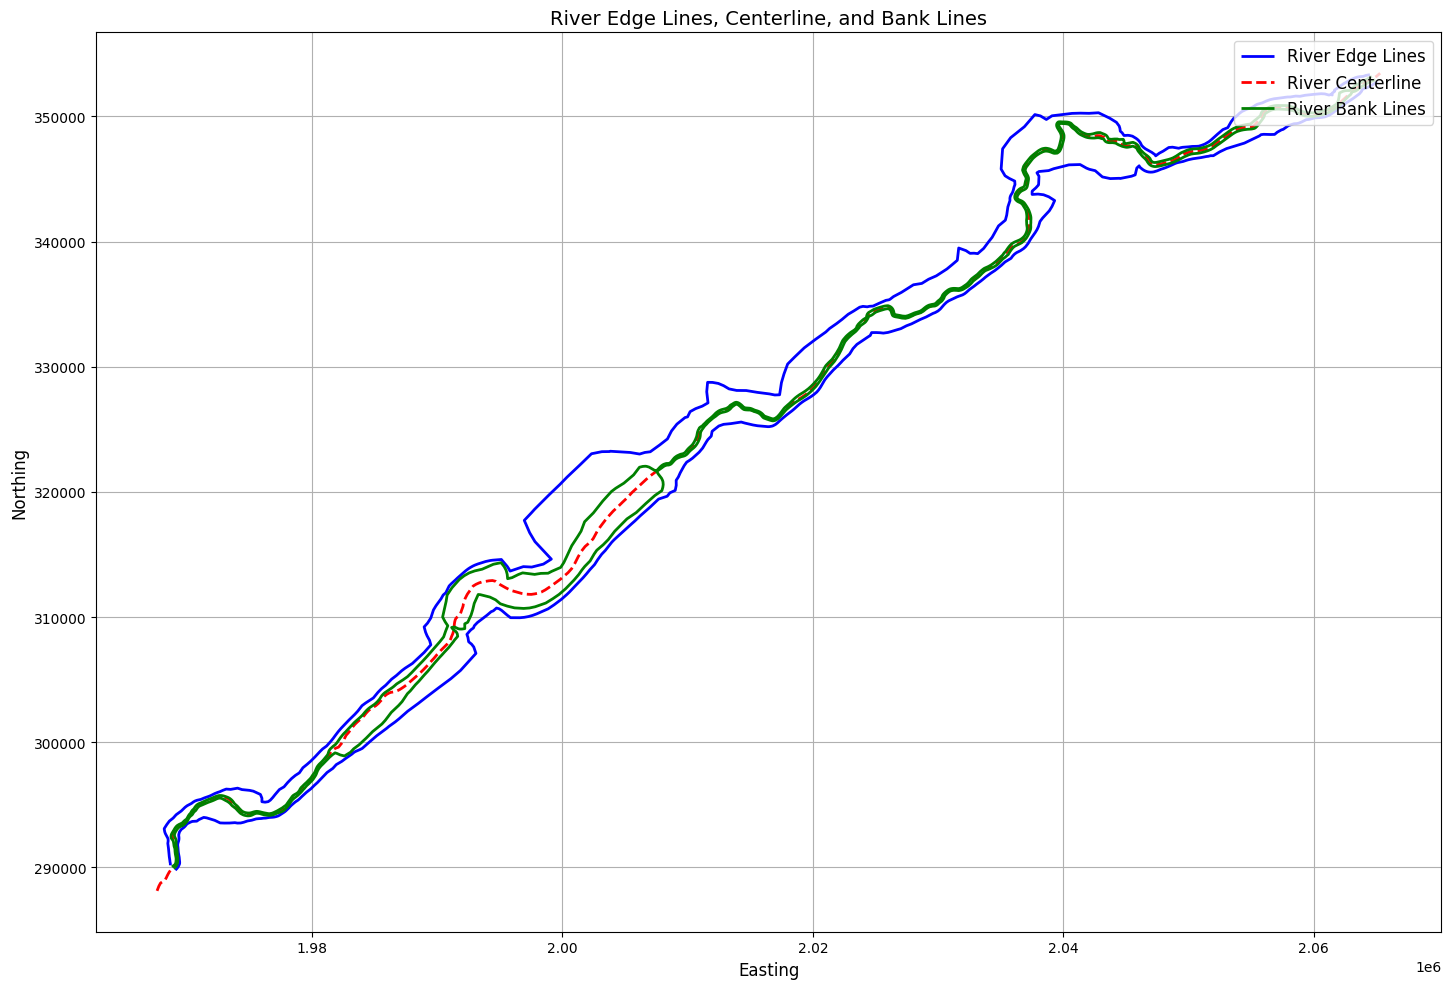

In [28]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(15, 10))

# Plot river edge lines
edge_lines.plot(ax=ax, color='blue', linewidth=2, label='River Edge Lines')

# Plot centerlines for reference
centerlines.plot(ax=ax, color='red', linewidth=2, linestyle='--', label='River Centerline')

# Plot river bank lines
bank_lines.plot(ax=ax, color='green', linewidth=2, label='River Bank Lines')

# Add title and labels
ax.set_title('River Edge Lines, Centerline, and Bank Lines', fontsize=14)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)

# Add legend
ax.legend(fontsize=12)

# Add grid
ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

In [29]:
# Use get_hdf5_dataset_info function to get dataset structure:
HdfBase.get_dataset_info(plan_hdf_path, "/Geometry/River Bank Lines/")

2025-03-15 08:38:50 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Exploring group: /Geometry/River Bank Lines/


    Dataset: /Geometry/River Bank Lines//Polyline Info
        Shape: (2, 4)
        Dtype: int32
    Attributes for /Geometry/River Bank Lines//Polyline Info:
        Column: [b'Point Starting Index' b'Point Count' b'Part Starting Index'
 b'Part Count']
        Feature Type: b'Polyline'
        Row: b'Feature'

    Dataset: /Geometry/River Bank Lines//Polyline Parts
        Shape: (2, 2)
        Dtype: int32
    Attributes for /Geometry/River Bank Lines//Polyline Parts:
        Column: [b'Point Starting Index' b'Point Count']
        Row: b'Part'

    Dataset: /Geometry/River Bank Lines//Polyline Points
        Shape: (1822, 2)
        Dtype: float64
    Attributes for /Geometry/River Bank Lines//Polyline Points:
        Column: [b'X' b'Y']
        Row: b'Points'


## Function to explore HDF file to assist with 1D Structures Data Extraction 

In [30]:
# Use get_hdf5_dataset_info function to get Pipe Conduits data:
HdfBase.get_dataset_info(plan_hdf_path, "/Results/Unsteady/Output/Output Blocks/Computation Block/Global/")

2025-03-15 08:38:50 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Exploring group: /Results/Unsteady/Output/Output Blocks/Computation Block/Global/


    Dataset: /Results/Unsteady/Output/Output Blocks/Computation Block/Global//1D Iteration Error
        Shape: (4471, 2)
        Dtype: float32
    Attributes for /Results/Unsteady/Output/Output Blocks/Computation Block/Global//1D Iteration Error:
        Variables: [b'1D Iteration Error ft' b'1D Iteration Error cfs']

    Dataset: /Results/Unsteady/Output/Output Blocks/Computation Block/Global//1D Iterations
        Shape: (4471, 2)
        Dtype: int32
    Attributes for /Results/Unsteady/Output/Output Blocks/Computation Block/Global//1D Iterations:
        Variables: [b'Number of Iterations' b'Cross Section pointer']

    Dataset: /Results/Unsteady/Output/Output Blocks/Computation Block/Global//Cross Section Only
        Shape: (178,)
        Dtype: |S42

    Dataset: /Results/Unsteady/Output/Output Blocks/Computation Block/Global//Time
        Shape: (4471,)
        Dtype: float64

    Dataset: /R

In [31]:
# Use get_hdf5_dataset_info function to get Pipe Conduits data:
HdfBase.get_dataset_info(plan_hdf_path, "/Geometry/Structures")


2025-03-15 08:38:50 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Exploring group: /Geometry/Structures


    Dataset: /Geometry/Structures/Abutment Attributes
        Shape: (2,)
        Dtype: [('Structure ID', '<i4'), ('US Profile (Index)', '<i4'), ('US Profile (Count)', '<i4'), ('DS Profile (Index)', '<i4'), ('DS Profile (Count)', '<i4')]

    Dataset: /Geometry/Structures/Abutment Data
        Shape: (8, 2)
        Dtype: float32

    Dataset: /Geometry/Structures/Attributes
        Shape: (11,)
        Dtype: [('Type', 'S16'), ('Mode', 'S16'), ('River', 'S16'), ('Reach', 'S16'), ('RS', 'S8'), ('Connection', 'S16'), ('Groupname', 'S45'), ('US Type', 'S16'), ('US River', 'S16'), ('US Reach', 'S16'), ('US RS', 'S8'), ('US SA/2D', 'S16'), ('DS Type', 'S16'), ('DS River', 'S16'), ('DS Reach', 'S16'), ('DS RS', 'S8'), ('DS SA/2D', 'S16'), ('Node Name', 'S16'), ('Description', 'S512'), ('Last Edited', 'S18'), ('Upstream Distance', '<f4'), ('Weir Width', '<f4'), ('Weir Max Submergence', '<f4'), ('Weir Min Elevation', '<f4'), ('Weir Coef', '<f4'), ('We

2025-03-15 08:38:50 - ras_commander.HdfStruc - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:50 - ras_commander.HdfBase - INFO - Using existing HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
2025-03-15 08:38:50 - ras_commander.HdfBase - CRITICAL - No valid projection found. Checked:
1. HDF file projection attribute: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.g01.hdf
 was checked and no projection attribute found2. No RASMapper projection file found
To fix this:
1. Open RASMapper
2. Click Map > Set Projection
3. Select an appropriate projection file or coordinate system
4. Save the RASMapper project
2025-03-15 08:38:50 - ras_commander.HdfStruc - INFO - Successfully extracted structures GeoDataFrame.
2025-03-15 08:38:50 - ras_commander.HdfStruc - INFO - Successfully extracted structures GeoDataFrame with attributes.
2025-03-15 08:38:50 - 


Structures Summary:
Number of structures found: 11

Structure Details:
   Structure ID
0             1
1             2
2             3
3             4
4             5


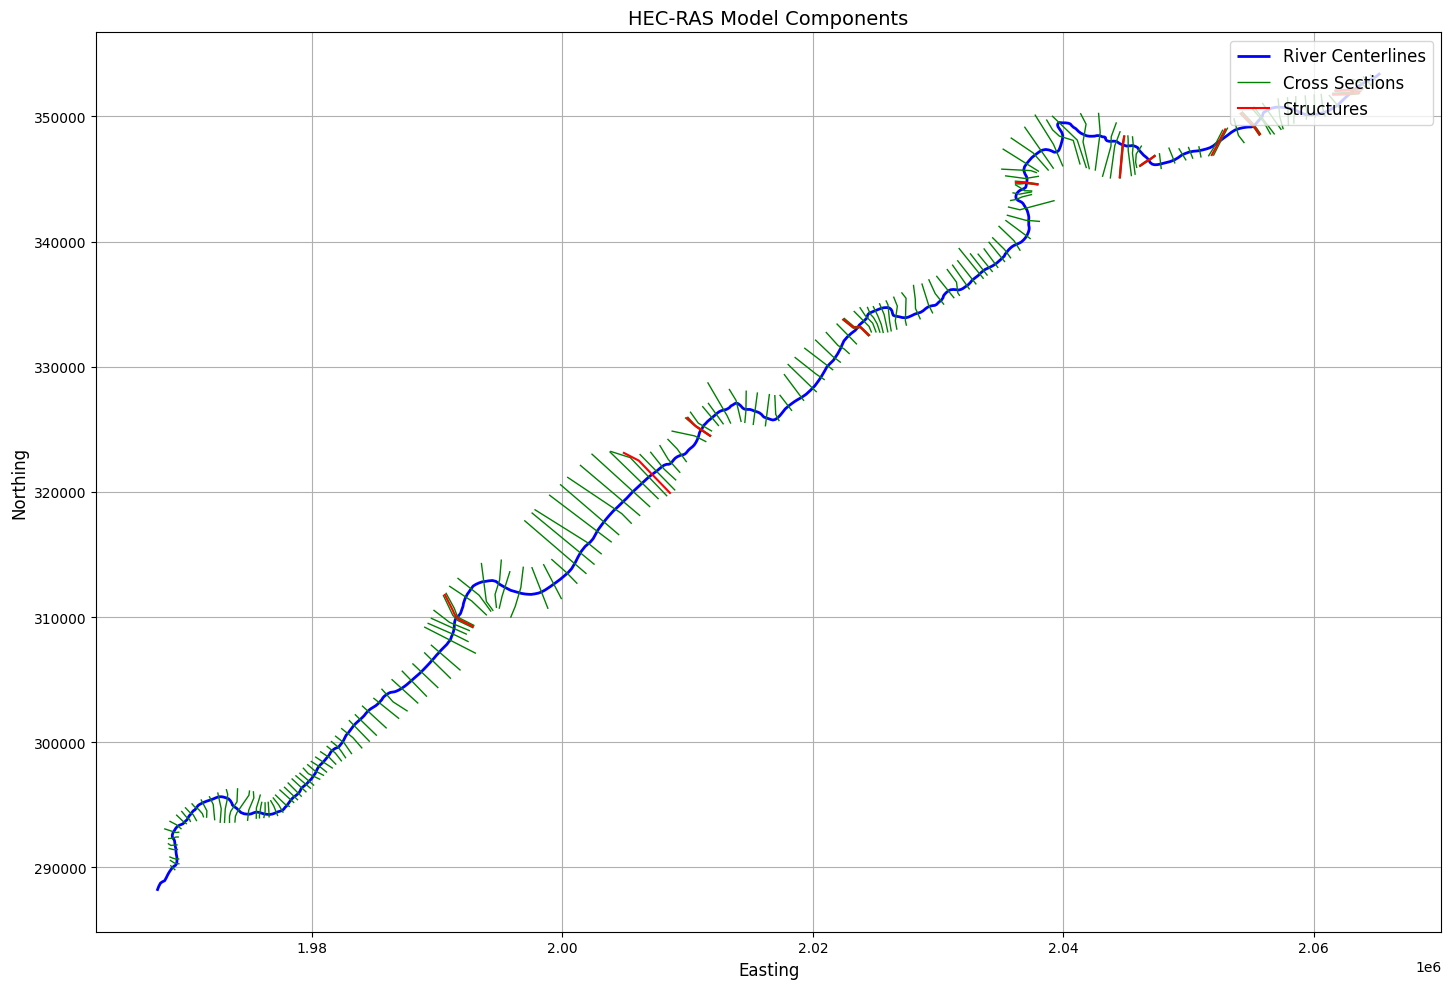


Cross Sections Summary:
Number of cross sections found: 178

Cross Section Details:
        River    Reach
0  Bald Eagle  Loc Hav
1  Bald Eagle  Loc Hav
2  Bald Eagle  Loc Hav
3  Bald Eagle  Loc Hav
4  Bald Eagle  Loc Hav


In [32]:
# Extract 1D Structures Geodataframe


# Extract data into GeoDataFrames
structures_gdf = HdfStruc.get_structures(hdf_path=geom_hdf_path)
cross_sections_gdf = HdfXsec.get_cross_sections(hdf_path=geom_hdf_path)
centerlines_gdf = HdfXsec.get_river_centerlines(hdf_path=geom_hdf_path)

# Display basic information about the structures
print("\nStructures Summary:")
print(f"Number of structures found: {len(structures_gdf)}")
structures_gdf

# Display first few rows of key attributes
print("\nStructure Details:")
display_cols = ['Structure ID', 'Structure Type', 'River Name', 'Reach Name', 'Station']
display_cols = [col for col in display_cols if col in structures_gdf.columns]
if display_cols:
    print(structures_gdf[display_cols].head())

# Create visualization
fig, ax = plt.subplots(figsize=(15, 10))

# Plot river centerlines
if not centerlines_gdf.empty:
    centerlines_gdf.plot(ax=ax, color='blue', linewidth=2, label='River Centerlines')

# Plot cross sections
if not cross_sections_gdf.empty:
    cross_sections_gdf.plot(ax=ax, color='green', linewidth=1, label='Cross Sections')

# Plot structures
if not structures_gdf.empty:
    structures_gdf.plot(ax=ax, color='red', marker='s', markersize=100, label='Structures')

# Add title and labels
ax.set_title('HEC-RAS Model Components', fontsize=14)
ax.set_xlabel('Easting', fontsize=12)
ax.set_ylabel('Northing', fontsize=12)

# Add legend
ax.legend(fontsize=12)

# Add grid
ax.grid(True)

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

# Print summary of cross sections
print("\nCross Sections Summary:")
print(f"Number of cross sections found: {len(cross_sections_gdf)}")
if not cross_sections_gdf.empty:
    print("\nCross Section Details:")
    xs_display_cols = ['River', 'Reach', 'Station']
    xs_display_cols = [col for col in xs_display_cols if col in cross_sections_gdf.columns]
    if xs_display_cols:
        print(cross_sections_gdf[xs_display_cols].head())


In [33]:
# Extract Compute Messages as String
print("Extracting Compute Messages")

import h5py
import numpy as np

def extract_string_from_hdf(results_hdf_filename: str, hdf_path: str) -> str:
    """
    Extract string from HDF object at a given path

    Parameters
    ----------
    results_hdf_filename : str
        Name of the HDF file
    hdf_path : str
        Path of the object in the HDF file

    Returns
    -------
    str
        Extracted string from the specified HDF object
    """
    with h5py.File(results_hdf_filename, 'r') as hdf_file:
        try:
            hdf_object = hdf_file[hdf_path]
            if isinstance(hdf_object, h5py.Group):
                return f"Group: {hdf_path}\nContents: {list(hdf_object.keys())}"
            elif isinstance(hdf_object, h5py.Dataset):
                data = hdf_object[()]
                if isinstance(data, bytes):
                    return data.decode('utf-8')
                elif isinstance(data, np.ndarray) and data.dtype.kind == 'S':
                    return [v.decode('utf-8') for v in data]
                else:
                    return str(data)
            else:
                return f"Unsupported object type: {type(hdf_object)}"
        except KeyError:
            return f"Path not found: {hdf_path}"

try:
    results_summary_string = extract_string_from_hdf(plan_hdf_path, '/Results/Summary/Compute Messages (text)')
    print("Compute Messages:")
    
    # Parse and print the compute messages in a more visually friendly way
    messages = results_summary_string[0].split('\r\n')
    
    for message in messages:
        if message.strip():  # Skip empty lines
            if ':' in message:
                key, value = message.split(':', 1)
                print(f"{key.strip():40} : {value.strip()}")
            else:
                print(f"\n{message.strip()}")
    
    # Print computation summary in a table format
    print("\nComputation Summary:")
    print("-" * 50)
    print(f"{'Computation Task':<30} {'Time':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Task' in line:
            task, time = line.split('\t')
            print(f"{task:<30} {time:<20}")
    
    print("\nComputation Speed:")
    print("-" * 50)
    print(f"{'Task':<30} {'Simulation/Runtime':<20}")
    print("-" * 50)
    for line in messages:
        if 'Computation Speed' in line:
            task, speed = line.split('\t')
            print(f"{task:<30} {speed:<20}")

except Exception as e:
    print(f"Error extracting compute messages: {str(e)}")
    print("\nNote: If 'Results/Summary Output' is not in the file structure, it might indicate that the simulation didn't complete successfully or the results weren't saved properly.")

 



Extracting Compute Messages
Compute Messages:
Plan                                     : 'Unsteady with Bridges and Dam' (BaldEagle.p01)
Simulation started at                    : 15Mar2025 08:34:01 AM

Writing Plan GIS Data...

Completed Writing Plan GIS Data

Writing Geometry...

Computing Bank Lines

Bank lines generated in 388 ms

Computing Edge Lines

Edge Lines generated in 154 ms

Computing XS Interpolation Surface

XS Interpolation Surface generated in 565 ms

Completed Writing Geometry

Writing Event Conditions ...

Completed Writing Event Condition Data

Geometric Preprocessor HEC-RAS 6.6 September 2024

Finished Processing Geometry

Performing Unsteady Flow Simulation  HEC-RAS 6.6 September 2024
Unsteady Input Summary                   : 

1D Unsteady Finite Difference Numerical Solution
Overall Volume Accounting Error in Acre Feet : -29.5468461514
Overall Volume Accounting Error as percentage : 0.01407

Please review "Computational Log File" output for volume accounting det

In [34]:
# Example 12: Extract Plan Parameters and Volume Accounting
print("\nExample 12: Extracting Plan Parameters and Volume Accounting Data")

# Extract plan parameters
plan_parameters_df = HdfPlan.get_plan_parameters(hdf_path=plan_hdf_path)

# Extract volume accounting data
volume_accounting_df = HdfResultsPlan.get_volume_accounting(hdf_path=plan_hdf_path)

print("\nPlan Parameters DataFrame:")
plan_parameters_df

print("\nVolume Accounting DataFrame:")
volume_accounting_df

2025-03-15 08:38:51 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf
2025-03-15 08:38:51 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Example 12: Extracting Plan Parameters and Volume Accounting Data

Plan Parameters DataFrame:

Volume Accounting DataFrame:


,Error,Error Percent,Total Boundary Flux of Water In,Total Boundary Flux of Water Out,Vol Accounting in,Volume Ending,Volume Starting
0,-29.546846,0.014071,200682.453125,112574.828125,b'Acre Feet',97384.882812,9306.797852


# RasPlanHdf Class Functions

In [35]:
# Example: Get simulation start time
start_time = HdfPlan.get_plan_start_time(plan_hdf_path)
print(f"Simulation start time: {start_time}")

2025-03-15 08:38:51 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf


Simulation start time: 1999-02-18 00:00:00


In [36]:
# Example: Get plan end time
end_time = HdfPlan.get_plan_end_time(plan_hdf_path)
print(f"Simulation end time: {end_time}")

2025-03-15 08:38:51 - ras_commander.HdfPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf


Simulation end time: 1999-02-24 05:00:00


## Modify the cell below to time of max wsel for 1D models

2025-03-15 08:38:51 - ras_commander.HdfResultsXsec - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Cross Section Results Shape: (150, 178)

Number of cross sections in geometry: 178

First few cross section names:
['Bald Eagle       Loc Hav          138154.4'
 'Bald Eagle       Loc Hav          137690.8'
 'Bald Eagle       Loc Hav          137327.0'
 'Bald Eagle       Loc Hav          136564.9'
 'Bald Eagle       Loc Hav          136202.3']

Number of cross sections processed: 178

Columns in xs_df: ['xs_name', 'x', 'y', 'max_wsel', 'time_of_max']

First row of xs_df:
xs_name        Bald Eagle       Loc Hav          138154.4
x                                              1968668.17
y                                               290166.79
max_wsel                                       672.808289
time_of_max                           1999-02-19 15:00:00
Name: 0, dtype: object


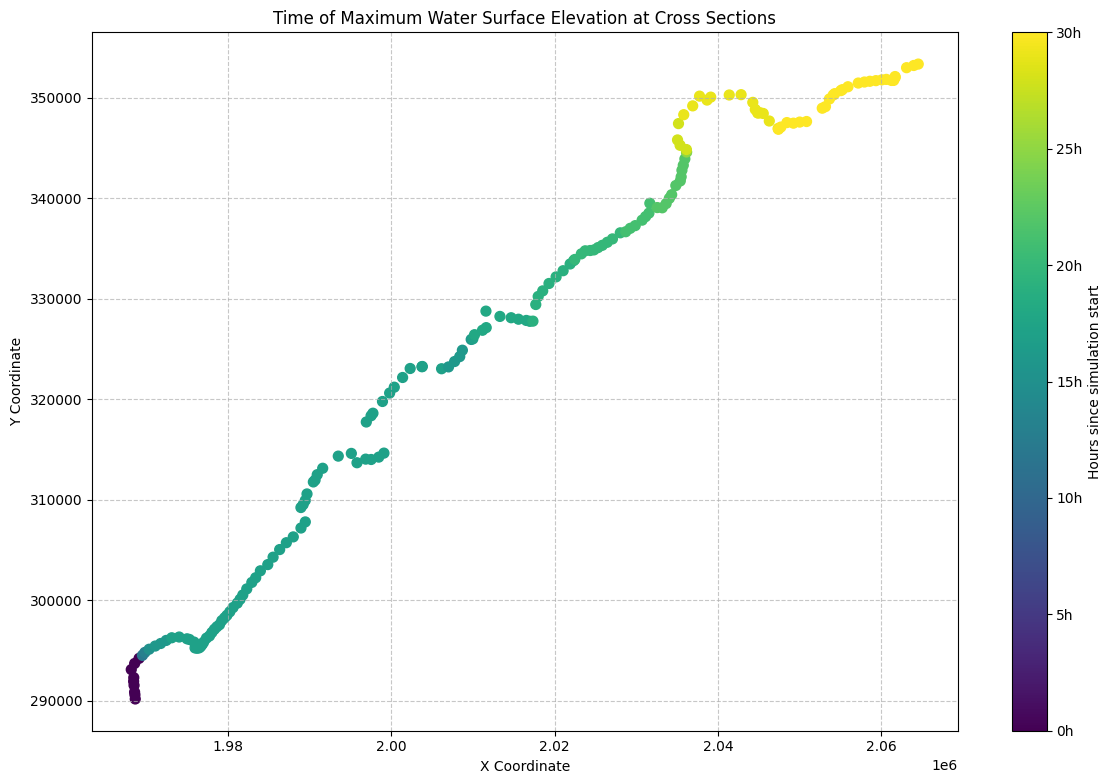


Overall Maximum WSEL: 672.81 ft
Time of Overall Maximum WSEL: 1999-02-19 15:00:00
Hours since simulation start: 0.00 hours
Location of Overall Maximum WSEL: X=1968668.17, Y=290166.79
Cross Section: Bald Eagle       Loc Hav          138154.4


In [37]:
# Plot the time of maximum water surface elevation (WSEL) for cross sections
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime

# Get cross section results timeseries
xsec_results = HdfResultsXsec.get_xsec_timeseries(plan_hdf_path)
print("\nCross Section Results Shape:", xsec_results['Water_Surface'].shape)

# Get cross section geometry data
xsec_geom = HdfXsec.get_cross_sections(plan_hdf_path)
print("\nNumber of cross sections in geometry:", len(xsec_geom))

# Create dataframe with cross section locations and max WSEL times
xs_data = []

# Extract water surface data from xarray Dataset
water_surface = xsec_results['Water_Surface'].values
times = pd.to_datetime(xsec_results.time.values)

# Debug print
print("\nFirst few cross section names:")
print(xsec_results.cross_section.values[:5])

# Iterate through cross sections
for xs_idx in range(len(xsec_results.cross_section)):
    # Get WSEL timeseries for this cross section
    wsel_series = water_surface[:, xs_idx]
    
    # Get cross section name and parse components
    xs_name = xsec_results.cross_section.values[xs_idx]
    
    # Split the string and remove empty strings
    xs_parts = [part for part in xs_name.split() if part]
    
    if len(xs_parts) >= 3:
        river = "Bald Eagle"  # Combine first two words
        reach = "Loc Hav"     # Next two words
        rs = xs_parts[-1]     # Last part is the station
        
        # Get geometry for this cross section
        xs_match = xsec_geom[
            (xsec_geom['River'] == river) & 
            (xsec_geom['Reach'] == reach) & 
            (xsec_geom['RS'] == rs)
        ]
        
        if not xs_match.empty:
            geom = xs_match.iloc[0]
            # Use first point of cross section line for plotting
            x = geom.geometry.coords[0][0]
            y = geom.geometry.coords[0][1]
            
            # Find time of max WSEL
            max_wsel_idx = np.argmax(wsel_series)
            max_wsel = np.max(wsel_series)
            max_time = times[max_wsel_idx]
            
            xs_data.append({
                'xs_name': xs_name,
                'x': x,
                'y': y,
                'max_wsel': max_wsel,
                'time_of_max': max_time
            })
        else:
            print(f"\nWarning: No geometry match found for {xs_name}")
            print(f"River: {river}, Reach: {reach}, RS: {rs}")
    else:
        print(f"\nWarning: Could not parse cross section name: {xs_name}")

# Create dataframe
xs_df = pd.DataFrame(xs_data)

# Debug print
print("\nNumber of cross sections processed:", len(xs_df))
if not xs_df.empty:
    print("\nColumns in xs_df:", xs_df.columns.tolist())
    print("\nFirst row of xs_df:")
    print(xs_df.iloc[0])

    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 8))

    # Convert datetime to hours since start for colormap
    min_time = min(xs_df['time_of_max'])
    color_values = [(t - min_time).total_seconds() / 3600 for t in xs_df['time_of_max']]

    # Plot cross section points
    scatter = ax.scatter(xs_df['x'], xs_df['y'],
                        c=color_values,
                        cmap='viridis',
                        s=50)

    # Customize plot
    ax.set_title('Time of Maximum Water Surface Elevation at Cross Sections')
    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')

    # Add colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Hours since simulation start')

    # Format colorbar ticks
    max_hours = int(max(color_values))
    tick_interval = max(1, max_hours // 6)  # Show ~6 ticks
    cbar.set_ticks(range(0, max_hours + 1, tick_interval))
    cbar.set_ticklabels([f'{h}h' for h in range(0, max_hours + 1, tick_interval)])

    # Add grid and adjust styling
    ax.grid(True, linestyle='--', alpha=0.7)
    plt.rcParams.update({'font.size': 12})
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print summary statistics
    max_wsel_xs = xs_df.loc[xs_df['max_wsel'].idxmax()]
    hours_since_start = (max_wsel_xs['time_of_max'] - min_time).total_seconds() / 3600

    print(f"\nOverall Maximum WSEL: {max_wsel_xs['max_wsel']:.2f} ft")
    print(f"Time of Overall Maximum WSEL: {max_wsel_xs['time_of_max']}")
    print(f"Hours since simulation start: {hours_since_start:.2f} hours")
    print(f"Location of Overall Maximum WSEL: X={max_wsel_xs['x']:.2f}, Y={max_wsel_xs['y']:.2f}")
    print(f"Cross Section: {max_wsel_xs['xs_name']}")
else:
    print("\nWarning: No cross sections were processed successfully")
    print("xs_data length:", len(xs_data))

### Need to add this to the ras-commander library

In [38]:
# Get unsteady attributes
results_unsteady_attrs = HdfResultsPlan.get_unsteady_info(plan_hdf_path)
print("\nResults Unsteady Attributes:")
for key, value in results_unsteady_attrs.items():
    print(f"{key}: {value}")

2025-03-15 08:38:53 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Results Unsteady Attributes:
Plan Title: 0    b'Unsteady with Bridges and Dam'
Name: Plan Title, dtype: object
Program Name: 0    b'HEC-RAS - River Analysis System'
Name: Program Name, dtype: object
Program Version: 0    b'HEC-RAS 6.6 September 2024'
Name: Program Version, dtype: object
Project File Name: 0    b'c:\\GH\\ras-commander\\examples\\example_pro...
Name: Project File Name, dtype: object
Project Title: 0    b'Bald Eagle Cr. for the WCDS Project'
Name: Project Title, dtype: object
Short ID: 0    b'UnsteadyFlow'
Name: Short ID, dtype: object
Simulation Time Window: 0    b'17Feb1999 2400 to 24Feb1999 0500'
Name: Simulation Time Window, dtype: object
Type of Run: 0    b'Unsteady Flow Analysis'
Name: Type of Run, dtype: object


In [39]:
# Get unsteady summary attributes
results_unsteady_summary_attrs = HdfResultsPlan.get_unsteady_summary(plan_hdf_path)
print("\nResults Unsteady Summary Attributes:")
for key, value in results_unsteady_summary_attrs.items():
    print(f"{key}: {value}")

# Get volume accounting attributes
volume_accounting_attrs = HdfResultsPlan.get_volume_accounting(plan_hdf_path)
print("\nVolume Accounting Attributes:")
for key, value in volume_accounting_attrs.items():
    print(f"{key}: {value}")

2025-03-15 08:38:53 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf
2025-03-15 08:38:53 - ras_commander.HdfResultsPlan - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



Results Unsteady Summary Attributes:
Computation Time DSS: 0    b'00:00:00'
Name: Computation Time DSS, dtype: object
Computation Time Total: 0    b'00:00:08'
Name: Computation Time Total, dtype: object
Maximum WSEL Error: 0    0.009995
Name: Maximum WSEL Error, dtype: float32
Maximum number of cores: 0    1
Name: Maximum number of cores, dtype: int32
Run Time Window: 0    b'15MAR2025 08:38:06 to 15MAR2025 08:38:13'
Name: Run Time Window, dtype: object
Solution: 0    b'Unsteady Finished Successfully'
Name: Solution, dtype: object
Time Solution Went Unstable: 0   NaN
Name: Time Solution Went Unstable, dtype: float32
Time Stamp Solution Went Unstable: 0    b'Not Applicable'
Name: Time Stamp Solution Went Unstable, dtype: object

Volume Accounting Attributes:
Error: 0   -29.546846
Name: Error, dtype: float32
Error Percent: 0    0.014071
Name: Error Percent, dtype: float32
Total Boundary Flux of Water In: 0    200682.453125
Name: Total Boundary Flux of Water In, dtype: float32
Total Bound

In [40]:
print("\n=== HDF5 File Structure ===\n")
print(plan_hdf_path)
HdfBase.get_dataset_info(plan_hdf_path, group_path='/Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections')

2025-03-15 08:38:53 - ras_commander.HdfBase - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf



=== HDF5 File Structure ===

c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf

Exploring group: /Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections


    Dataset: /Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections/Cross Section Attributes
        Shape: (178,)
        Dtype: [('River', 'S16'), ('Reach', 'S16'), ('Station', 'S8'), ('Name', 'S16')]

    Dataset: /Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections/Cross Section Only
        Shape: (178,)
        Dtype: |S42

    Dataset: /Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections/Flow
        Shape: (150, 178)
        Dtype: float32
    Attributes for /Results/Unsteady/Output/Output Blocks/Base Output/Unsteady Time Series/Cross Sections/Flow:
        Maximum Value of Data Set: 50000.0
        Minimum Value of Data Set: 1235.9544677734375
        Variable: [b

In [41]:
xsec_results = HdfResultsXsec.get_xsec_timeseries(plan_hdf_path)
print(xsec_results)

2025-03-15 08:38:53 - ras_commander.HdfResultsXsec - INFO - Using HDF file: c:\GH\ras-commander\examples\example_projects\Balde Eagle Creek\BaldEagle.p01.hdf


<xarray.Dataset> Size: 587kB
Dimensions:                   (time: 150, cross_section: 178)
Coordinates:
  * time                      (time) datetime64[ns] 1kB 1999-02-18 ... 1999-0...
  * cross_section             (cross_section) <U42 30kB 'Bald Eagle       Loc...
    River                     (cross_section) <U10 7kB 'Bald Eagle' ... 'Bald...
    Reach                     (cross_section) <U7 5kB 'Loc Hav' ... 'Loc Hav'
    Station                   (cross_section) <U8 6kB '138154.4' ... '659.942'
    Name                      (cross_section) <U1 712B '' '' '' '' ... '' '' ''
    Maximum_Water_Surface     (cross_section) float32 712B 672.8 672.8 ... 561.4
    Maximum_Flow              (cross_section) float32 712B 5e+04 ... 2.543e+04
    Maximum_Channel_Velocity  (cross_section) float32 712B 11.81 8.031 ... 2.028
    Maximum_Velocity_Total    (cross_section) float32 712B 9.371 5.379 ... 1.632
    Maximum_Flow_Lateral      (cross_section) float32 712B 0.0 0.0 ... 0.0 0.0
Data variables:


Time Series Data for Cross Section: Bald Eagle       Loc Hav          136202.3

Water_Surface:
[657.4173  656.7111  657.02997 657.44073 657.88824]

Velocity_Total:
[0.        2.7810786 2.9612713 2.9395368 3.0228102]

Velocity_Channel:
[0.        3.132834  3.4508243 3.7217746 4.083391 ]

Flow_Lateral:
[0. 0. 0. 0. 0.]

Flow:
[2000.     1273.8193 1607.1132 2109.992  2746.2964]


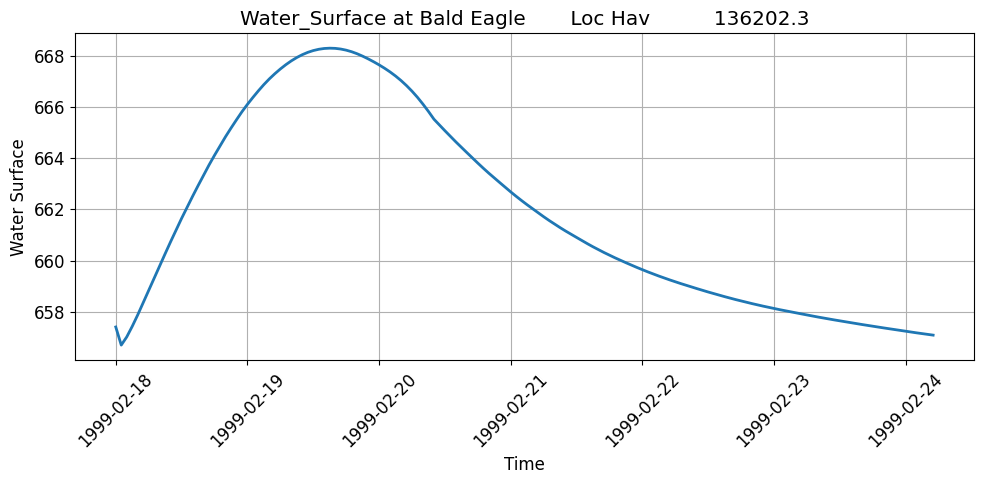

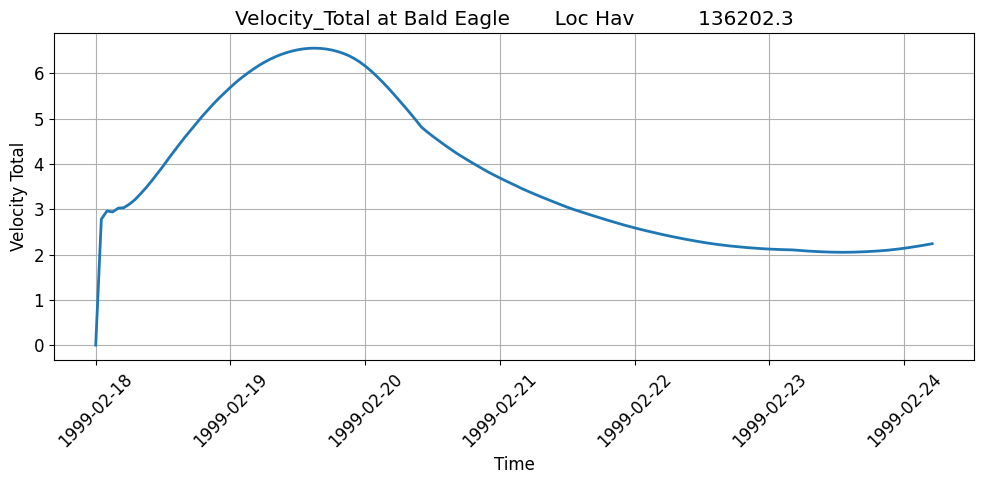

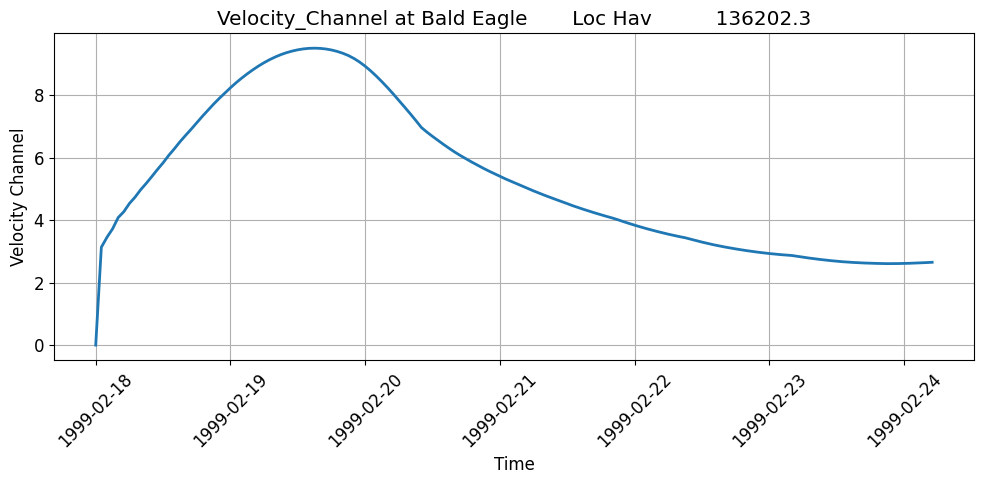

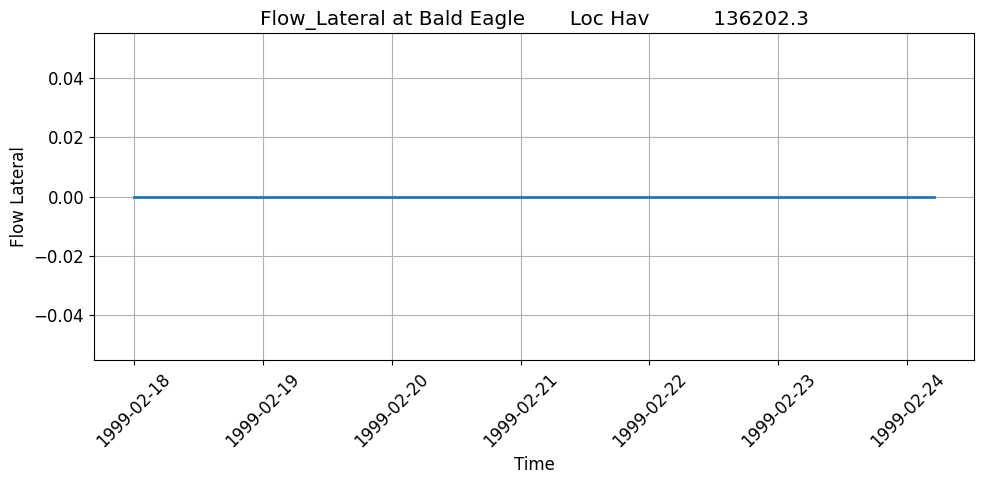

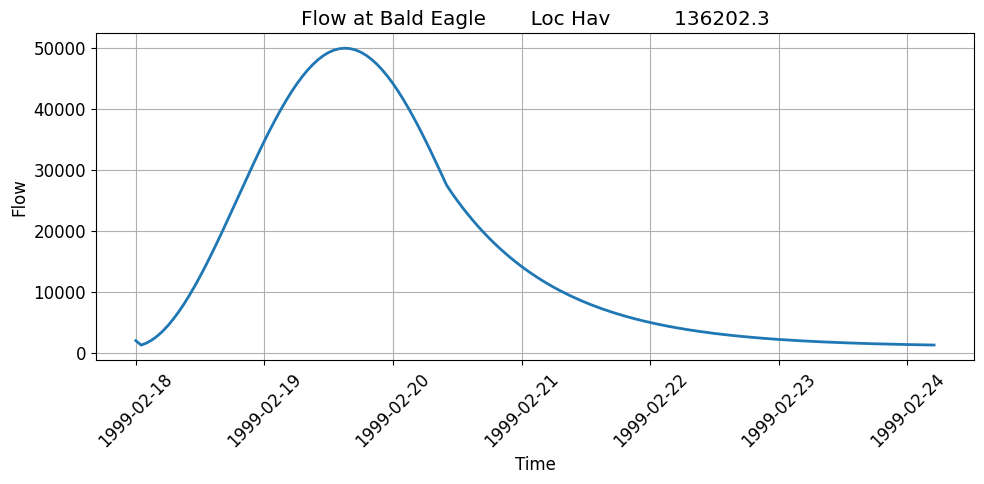

In [42]:
# Print time series for specific cross section
target_xs = "Bald Eagle       Loc Hav          136202.3"

print("\nTime Series Data for Cross Section:", target_xs)
for var in ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']:
    print(f"\n{var}:")
    print(xsec_results[var].sel(cross_section=target_xs).values[:5])  # Show first 5 values

# Create time series plots
import matplotlib.pyplot as plt

# Create a figure for each variable
variables = ['Water_Surface', 'Velocity_Total', 'Velocity_Channel', 'Flow_Lateral', 'Flow']

for var in variables:
    plt.figure(figsize=(10, 5))
    # Convert time values to datetime if needed
    time_values = pd.to_datetime(xsec_results.time.values)
    values = xsec_results[var].sel(cross_section=target_xs).values
    
    # Plot with explicit x and y values
    plt.plot(time_values, values, '-', linewidth=2)
    
    plt.title(f'{var} at {target_xs}')
    plt.xlabel('Time')
    plt.ylabel(var.replace('_', ' '))
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Force display
    plt.draw()
    plt.pause(0.1)
    plt.show()
